In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import datetime # used to record the time it took to experiment epochs and learning rates

In [2]:
df = pd.read_csv(r"bodyfat.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Density  252 non-null    float64
 1   BodyFat  252 non-null    float64
 2   Age      252 non-null    int64  
 3   Weight   252 non-null    float64
 4   Height   252 non-null    float64
 5   Neck     252 non-null    float64
 6   Chest    252 non-null    float64
 7   Abdomen  252 non-null    float64
 8   Hip      252 non-null    float64
 9   Thigh    252 non-null    float64
 10  Knee     252 non-null    float64
 11  Ankle    252 non-null    float64
 12  Biceps   252 non-null    float64
 13  Forearm  252 non-null    float64
 14  Wrist    252 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 29.7 KB


In [4]:
df.describe()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,1.055574,19.150794,44.884921,178.924405,70.148810,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,0.019031,8.368740,12.602040,29.389160,3.662856,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.995000,0.000000,22.000000,118.500000,29.500000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,1.041400,12.475000,35.750000,159.000000,68.250000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,1.054900,19.200000,43.000000,176.500000,70.000000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,1.070400,25.300000,54.000000,197.000000,72.250000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,1.108900,47.500000,81.000000,363.150000,77.750000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


In [5]:
df.isna().sum()

Density    0
BodyFat    0
Age        0
Weight     0
Height     0
Neck       0
Chest      0
Abdomen    0
Hip        0
Thigh      0
Knee       0
Ankle      0
Biceps     0
Forearm    0
Wrist      0
dtype: int64

In [6]:
df = df.astype({"Age":"float64"})

In [7]:
df = df.drop(columns="Density") # remove density. not planning on utilizing body density as a variable due to accesibility reasons

In [8]:
def winsorize(data, x, lower, upper):
    # winsorize method caps the extreme high and low values back to the chosen percentile
    # lower: lower percentile bound
    # upper: upper percentile bound
    lower = np.percentile(data[x], lower)
    upper = np.percentile(data[x], upper)
    data.loc[
        :,
        data[x].name
    ] = np.clip(data[x], a_min=lower, a_max=upper) 
    return data

In [9]:
def display_graph(data, x):
    # display_graph method displays graphical visualization of the datapoints
    # boxplot (to see outliers)
    # histogram (to see frequency distribution of values of features)
    # scatter (to see linear relation of the selected feature to the target feature BodyFat)
    fig, axs = plot.subplots(2, 2)
    axs[0, 0].boxplot(data[x])
    axs[0, 0].set_ylabel(data[x].name)
    axs[0, 1].hist(data[x], bins=15)
    axs[0, 1].set_xlabel(data[x].name)
    axs[1, 0].scatter(data[x], data["BodyFat"])
    axs[1, 0].set_xlabel(data[x].name)
    axs[1, 0].set_ylabel("BodyFat")
    fig.tight_layout() # optional. i put this to properly fit each plot in the figure without overlapping
    plot.show()

- split dataset into train, valid, and test
- use a validation set to tweak hyperparameters of linear regression gradient descent, to lower the cost function

In [10]:
df = df.sample(frac=1, random_state=1)
train_count = round(df.shape[0] * 0.7)
valid_test_count = round(df.shape[0] * 0.15)
train_set = pd.DataFrame(df[:train_count])
valid_set = pd.DataFrame(df[train_count:train_count+valid_test_count])
test_set = pd.DataFrame(df[train_count+valid_test_count:])

## Basic EDA: visualization of data and handling of outliers (winsorization)

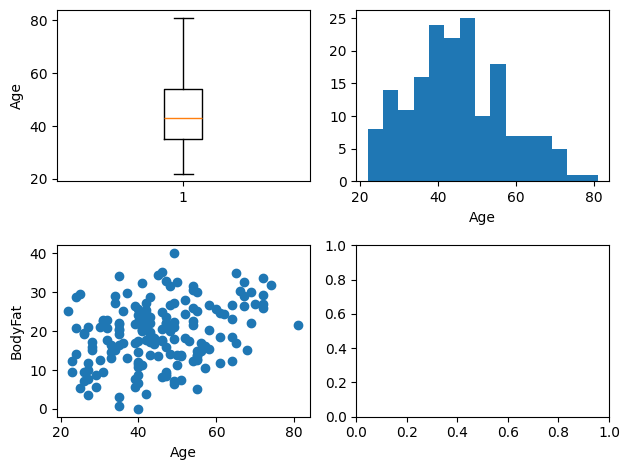

In [11]:
display_graph(train_set, "Age")

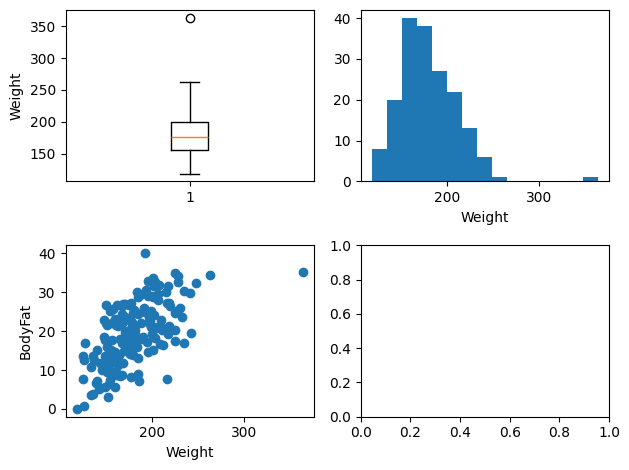

In [12]:
display_graph(train_set, "Weight")

- outliers exist. try winsorization to handle outlier
- as much as possible, dont drop records because the dataset is small
- winsorization may ruin the linear relation between independent and dependent variable, which could affect generalization in model creation due to skewed frequency, so check for changes first
- experimented with
  - 95th percentile but change in frequency distribution is too large (frequency pooling on tails),
  - 99th percentile but some outliers remained on some features
  - used 98th and 97th percentile instead on some features that have outliers remaining

In [13]:
train_set[["BodyFat", "Weight"]].corr()

,BodyFat,Weight
BodyFat,1.000000,0.633304
Weight,0.633304,1.000000


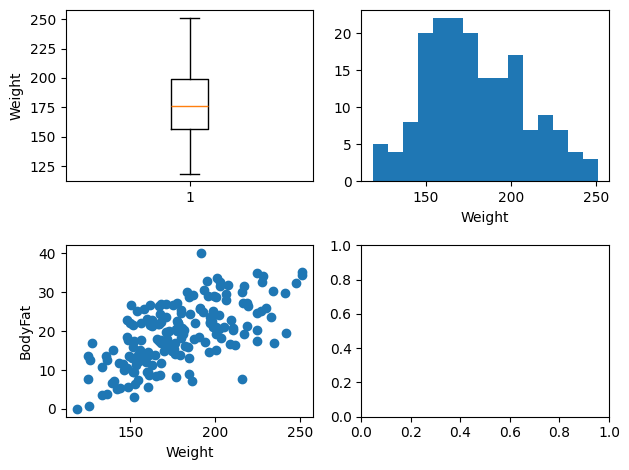

In [14]:
winsorize(train_set, "Weight", 0, 99)
display_graph(train_set, "Weight")

In [15]:
train_set[["BodyFat", "Weight"]].corr()

,BodyFat,Weight
BodyFat,1.000000,0.647366
Weight,0.647366,1.000000


- not much change in the linearity of the weight attribute to the body fat, continue doing winsorization for outliers

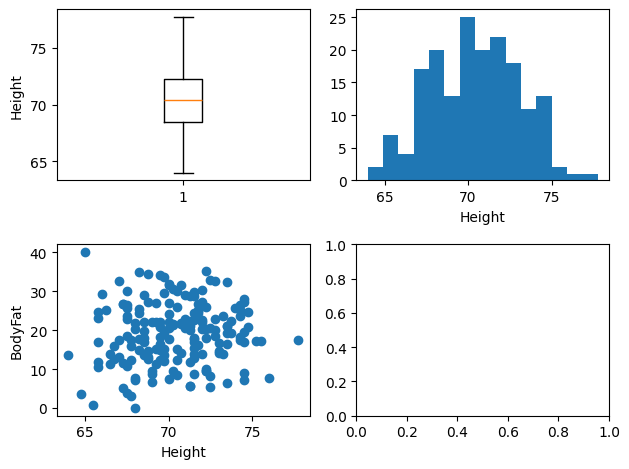

In [16]:
display_graph(train_set, "Height")

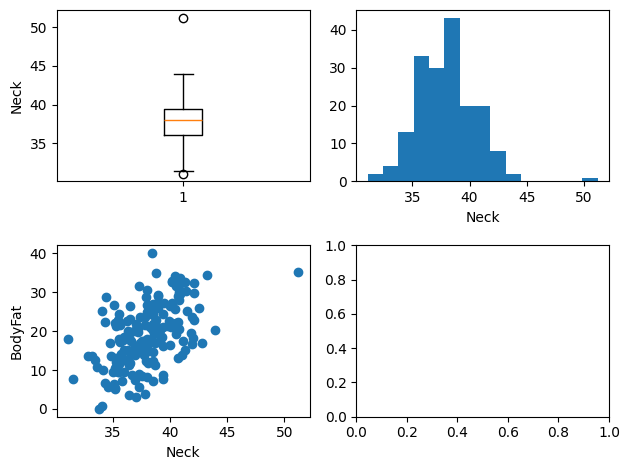

In [17]:
display_graph(train_set, "Neck")

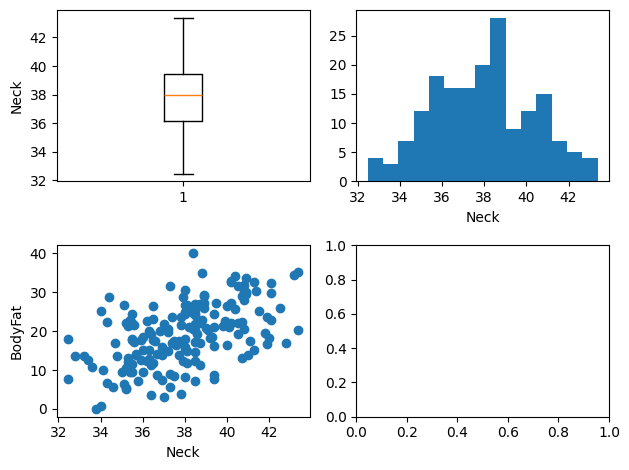

In [18]:
winsorize(train_set, "Neck", 1, 99)
display_graph(train_set, "Neck")

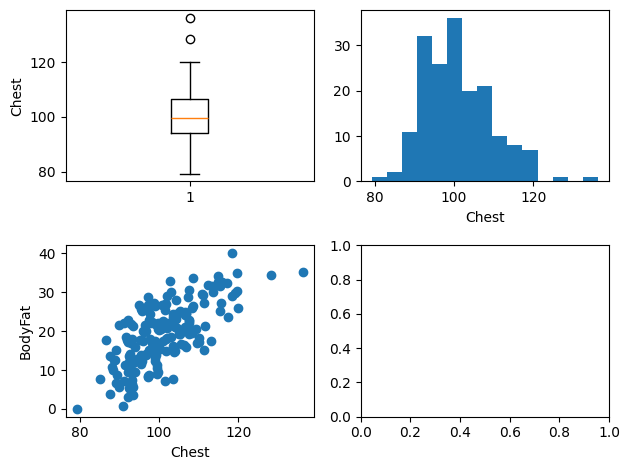

In [19]:
display_graph(train_set, "Chest")

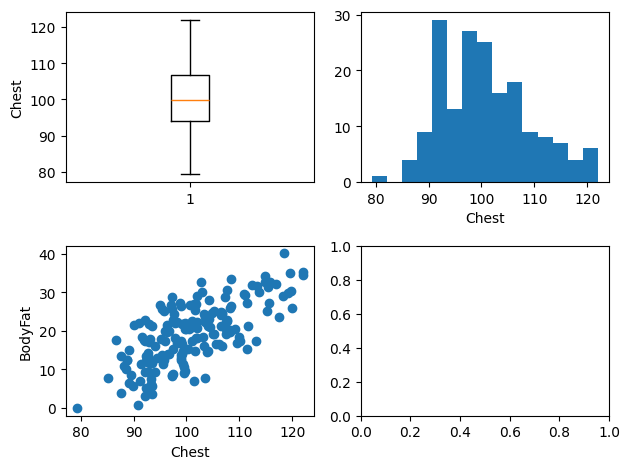

In [20]:
winsorize(train_set, "Chest", 0, 99)
display_graph(train_set, "Chest")

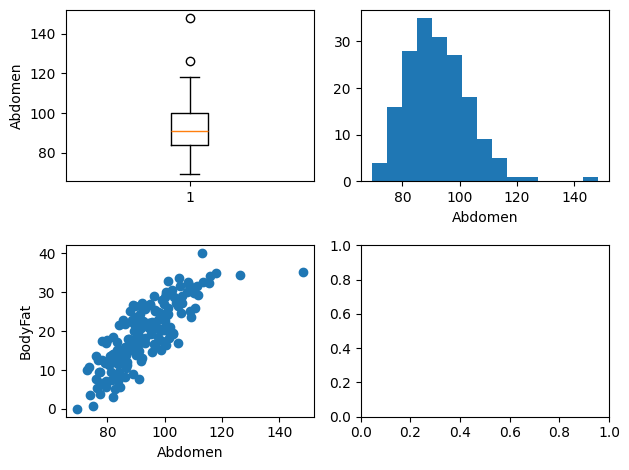

In [21]:
display_graph(train_set, "Abdomen")

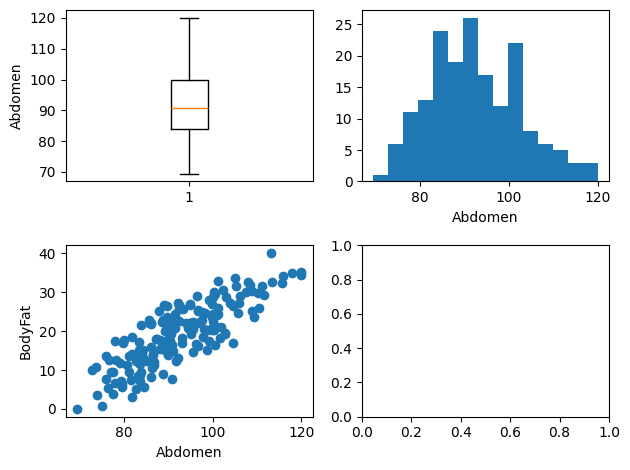

In [22]:
winsorize(train_set, "Abdomen", 0, 99)
display_graph(train_set, "Abdomen")

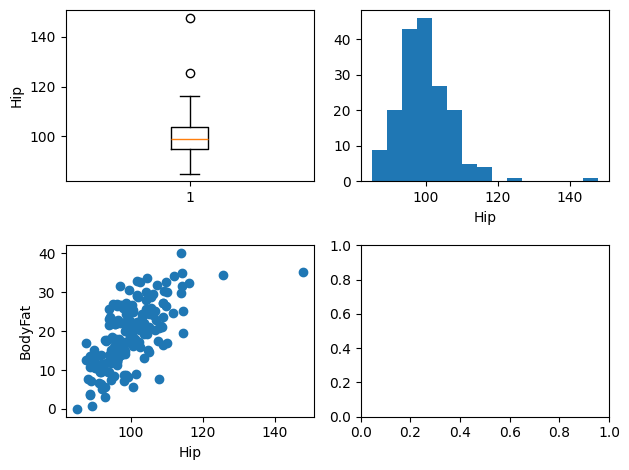

In [23]:
display_graph(train_set, "Hip")

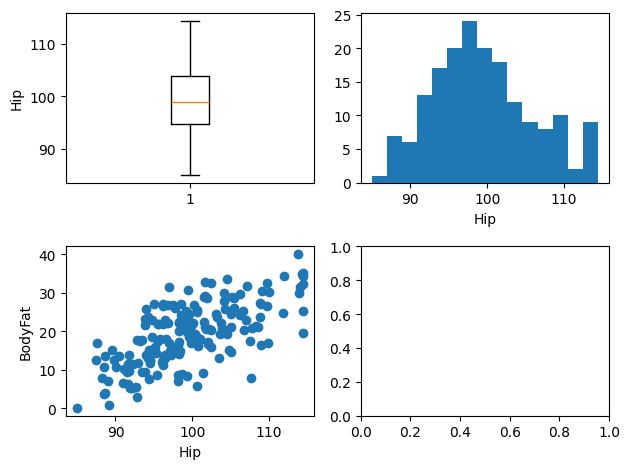

In [24]:
winsorize(train_set, "Hip", 0, 98)
display_graph(train_set, "Hip")

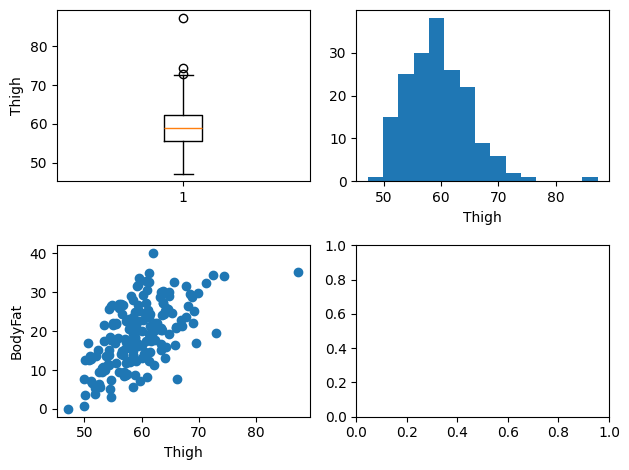

In [25]:
display_graph(train_set, "Thigh")

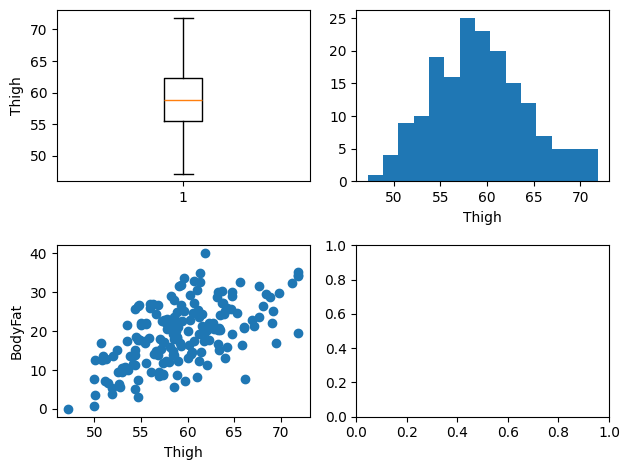

In [26]:
winsorize(train_set, "Thigh", 0, 98)
display_graph(train_set, "Thigh")

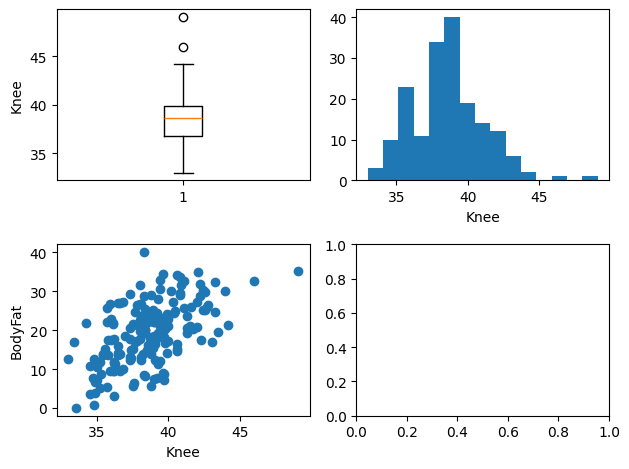

In [27]:
display_graph(train_set, "Knee")

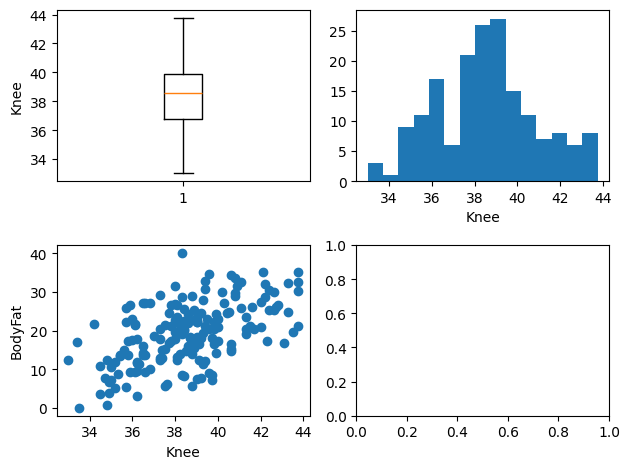

In [28]:
winsorize(train_set, "Knee", 0, 98)
display_graph(train_set, "Knee")

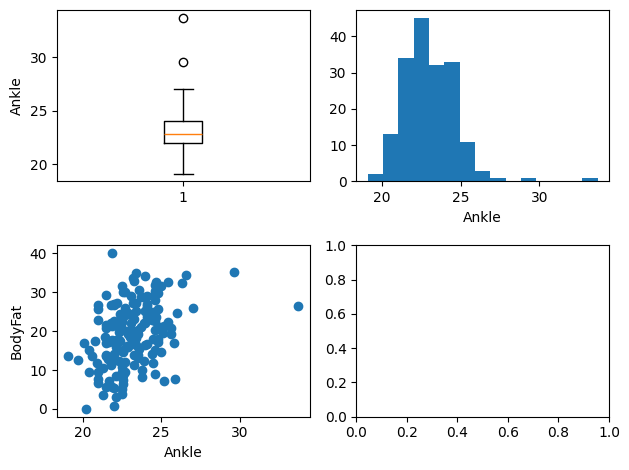

In [29]:
display_graph(train_set, "Ankle")

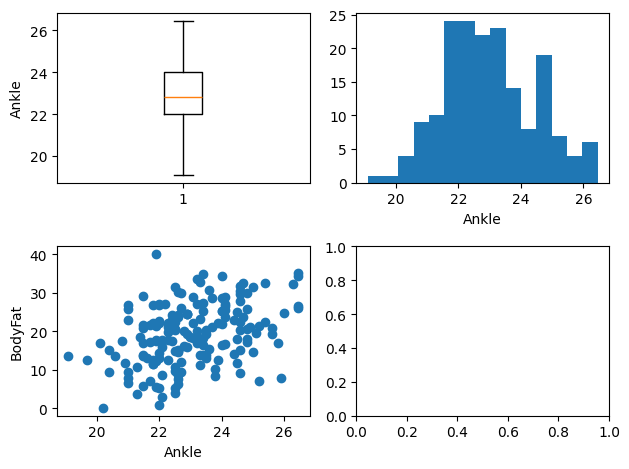

In [30]:
winsorize(train_set, "Ankle", 0, 98)
display_graph(train_set, "Ankle")

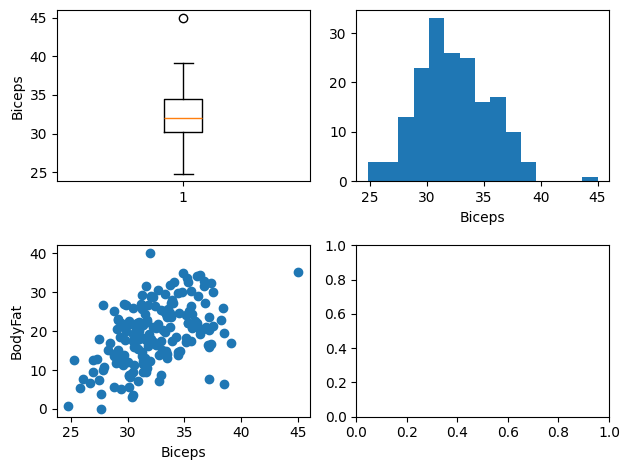

In [31]:
display_graph(train_set, "Biceps")

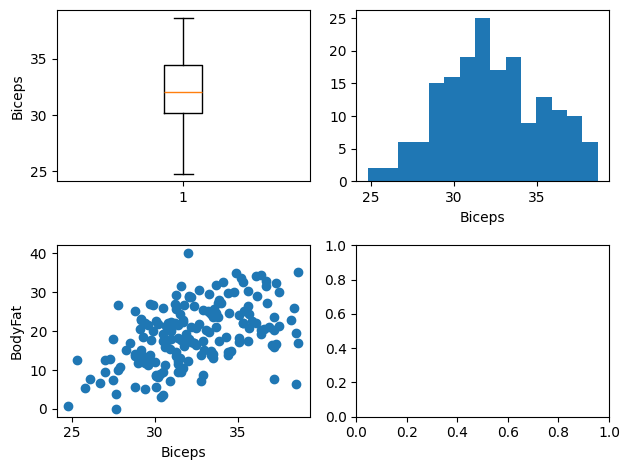

In [32]:
winsorize(train_set, "Biceps", 0, 99)
display_graph(train_set, "Biceps")

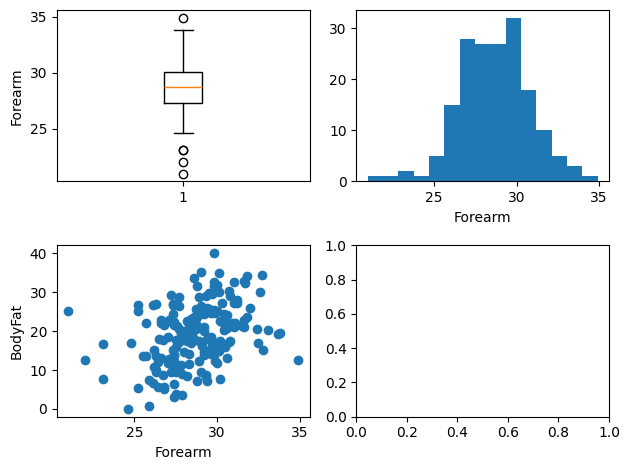

In [33]:
display_graph(train_set, "Forearm")

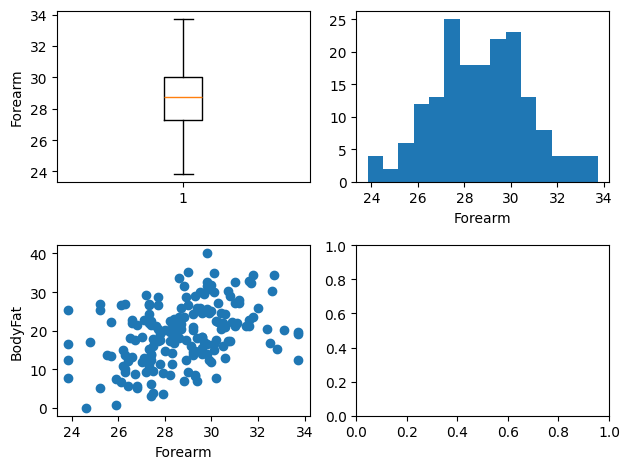

In [34]:
winsorize(train_set, "Forearm", 2, 99)
display_graph(train_set, "Forearm")

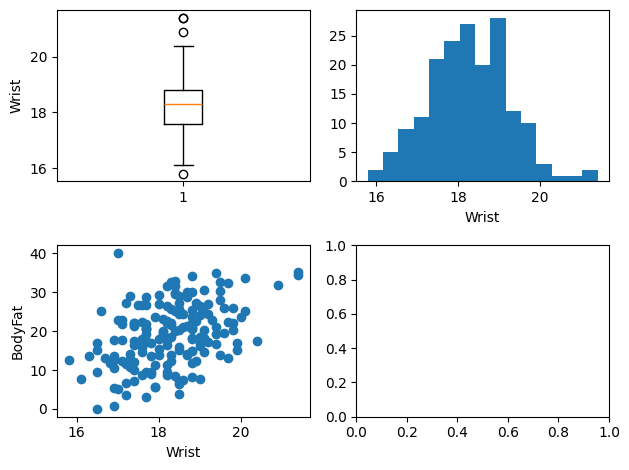

In [35]:
display_graph(train_set, "Wrist")

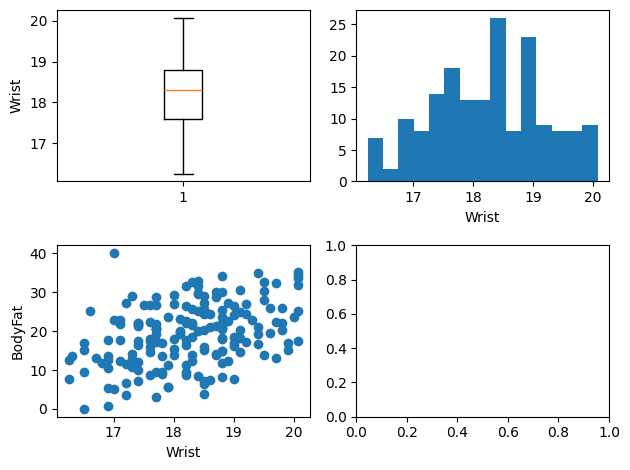

In [36]:
winsorize(train_set, "Wrist", 1, 97)
display_graph(train_set, "Wrist")

- remaining outliers from winsorized attributes are not too far from the ideal value range, frequency distribution and scatter plot still suggest a good relation

## Basic EDA: check for multicollinearity (correlation between all variables)

In [37]:
train_set.corr()

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
BodyFat,1.000000,0.312048,0.647366,0.082154,0.520916,0.707586,0.828154,0.669521,0.584554,0.554313,0.382664,0.485702,0.390770,0.397310
Age,0.312048,1.000000,0.006891,-0.201973,0.122228,0.197415,0.249551,-0.033691,-0.187733,0.021144,-0.113156,-0.030076,-0.077430,0.207660
Weight,0.647366,0.006891,1.000000,0.558271,0.835503,0.901229,0.890351,0.936077,0.863696,0.866909,0.748726,0.787348,0.695673,0.760923
Height,0.082154,-0.201973,0.558271,1.000000,0.384879,0.298513,0.271526,0.454871,0.386712,0.541805,0.496217,0.371696,0.360486,0.457326
Neck,0.520916,0.122228,0.835503,0.384879,1.000000,0.799772,0.763392,0.734821,0.709264,0.672710,0.585384,0.724006,0.682275,0.771569
Chest,0.707586,0.197415,0.901229,0.298513,0.799772,1.000000,0.912212,0.837465,0.734558,0.751975,0.626378,0.706718,0.622053,0.687522
Abdomen,0.828154,0.249551,0.890351,0.271526,0.763392,0.912212,1.000000,0.876112,0.768364,0.758117,0.577836,0.670326,0.563456,0.653057
Hip,0.669521,-0.033691,0.936077,0.454871,0.734821,0.837465,0.876112,1.000000,0.894624,0.848690,0.667750,0.732293,0.615956,0.650623
Thigh,0.584554,-0.187733,0.863696,0.386712,0.709264,0.734558,0.768364,0.894624,1.000000,0.787208,0.671919,0.752373,0.615158,0.585436
Knee,0.554313,0.021144,0.866909,0.541805,0.672710,0.751975,0.758117,0.848690,0.787208,1.000000,0.744788,0.678904,0.598859,0.692760


In [38]:
train_set.corr()[
    train_set.corr() <= -0.7
]

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
BodyFat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Height,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neck,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abdomen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Thigh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Knee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
train_set.corr()[
    train_set.corr() > 0.7
]

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
BodyFat,1.000000,NaN,NaN,NaN,NaN,0.707586,0.828154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weight,NaN,NaN,1.000000,NaN,0.835503,0.901229,0.890351,0.936077,0.863696,0.866909,0.748726,0.787348,NaN,0.760923
Height,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neck,NaN,NaN,0.835503,NaN,1.000000,0.799772,0.763392,0.734821,0.709264,NaN,NaN,0.724006,NaN,0.771569
Chest,0.707586,NaN,0.901229,NaN,0.799772,1.000000,0.912212,0.837465,0.734558,0.751975,NaN,0.706718,NaN,NaN
Abdomen,0.828154,NaN,0.890351,NaN,0.763392,0.912212,1.000000,0.876112,0.768364,0.758117,NaN,NaN,NaN,NaN
Hip,NaN,NaN,0.936077,NaN,0.734821,0.837465,0.876112,1.000000,0.894624,0.848690,NaN,0.732293,NaN,NaN
Thigh,NaN,NaN,0.863696,NaN,0.709264,0.734558,0.768364,0.894624,1.000000,0.787208,NaN,0.752373,NaN,NaN
Knee,NaN,NaN,0.866909,NaN,NaN,0.751975,0.758117,0.848690,0.787208,1.000000,0.744788,NaN,NaN,NaN


## feature engineering step 1
- list of independent features and how much features they are strongly correlated with (70% correlation)
- age: 0
- weight: 9
- height: 0
- neck: 7
- chest: 7
- abdomen: 6
- hip: 7
- thigh: 7
- knee: 6
- ankle: 2
- biceps: 5
- forearm: 0
- wrist: 2

weight has the most correlation. as much as possible, i dont want to drop features, especially that weight can have a relation with bodyfat
i could try to transform it, along with height, by creating a BMI feature instead  
action: create BMI feature, drop weight and height features

In [40]:
train_set.loc[
    :,
    "BMI"
] = 703 * (train_set["Weight"] / (train_set["Height"] * train_set["Height"]))
train_set["BMI"]

67     21.280111
251    29.769898
231    24.887373
161    25.856258
91     26.161017
         ...    
155    21.291509
100    25.830996
125    26.153041
23     21.341071
126    26.400264
Name: BMI, Length: 176, dtype: float64

In [41]:
train_set = train_set.drop(columns=["Height", "Weight"])
train_set

,BodyFat,Age,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI
67,13.8,55.0,36.9,95.4,86.6,91.8,54.3,35.4,21.5,32.8,27.4,18.700,21.280111
251,31.9,74.0,40.8,112.4,108.5,107.1,59.3,42.2,24.6,33.7,30.0,20.075,29.769898
231,16.1,57.0,39.4,103.4,96.7,100.7,59.3,38.6,22.8,31.8,29.1,19.000,24.887373
161,14.6,33.0,38.5,103.8,95.6,105.1,61.4,40.6,25.0,31.3,29.2,19.100,25.856258
91,18.2,44.0,39.2,101.9,93.2,100.6,58.9,39.7,23.1,31.4,28.4,18.800,26.161017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,17.3,28.0,35.6,92.1,83.5,98.3,57.3,37.8,21.7,32.2,27.7,17.700,21.291509
100,21.2,49.0,40.1,106.5,95.0,101.7,59.0,39.4,22.3,32.2,31.0,18.600,25.830996
125,17.5,46.0,36.6,101.0,89.9,100.0,60.7,36.0,21.9,35.6,30.2,17.600,26.153041
23,17.7,32.0,35.5,86.7,80.0,93.4,54.9,36.2,22.1,29.8,26.7,17.100,21.341071


In [42]:
train_set.corr()[
    train_set.corr() > 0.7
]

,BodyFat,Age,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI
BodyFat,1.000000,NaN,NaN,0.707586,0.828154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.741669
Age,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neck,NaN,NaN,1.000000,0.799772,0.763392,0.734821,0.709264,NaN,NaN,0.724006,NaN,0.771569,0.784953
Chest,0.707586,NaN,0.799772,1.000000,0.912212,0.837465,0.734558,0.751975,NaN,0.706718,NaN,NaN,0.917257
Abdomen,0.828154,NaN,0.763392,0.912212,1.000000,0.876112,0.768364,0.758117,NaN,NaN,NaN,NaN,0.921240
Hip,NaN,NaN,0.734821,0.837465,0.876112,1.000000,0.894624,0.848690,NaN,0.732293,NaN,NaN,0.872264
Thigh,NaN,NaN,0.709264,0.734558,0.768364,0.894624,1.000000,0.787208,NaN,0.752373,NaN,NaN,0.819934
Knee,NaN,NaN,NaN,0.751975,0.758117,0.848690,0.787208,1.000000,0.744788,NaN,NaN,NaN,0.738801
Ankle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.744788,1.000000,NaN,NaN,NaN,NaN
Biceps,NaN,NaN,0.724006,0.706718,NaN,0.732293,0.752373,NaN,NaN,1.000000,NaN,NaN,0.734968


## feature engineering step 2
- @ 70% correlation (excluding engineered features)
- age: 0
- neck: 6
- chest: 6
- abdomen: 5
- hip: 6
- thigh: 6
- knee: 5
- ankle: 1
- biceps: 4
- forearm: 0
- wrist: 1

top 10 feature pairs with high correlations, ranked:
1. chest-abdomen 0.91
2. hip-thigh 0.89
3. abdomen-hip 0.87
4. knee-hip 0.84
5. hip-chest 0.83
6. neck-chest 0.79
7. knee-thigh 0.78
8. wrist-neck 0.77
9. bicep-thigh 0.75
10. bicep-hip 0.73

combining chest + abdomen & hip + thigh eliminates 9 of the top 10 highest multicollinearity  
action: combine chest+abdomen and hip+thigh , drop chest, abdomen, hip, thigh

In [43]:
train_set.loc[
    :,
    "Chest-Abdomen"
] = train_set["Chest"] / train_set["Abdomen"]
train_set["Chest-Abdomen"]

67     1.101617
251    1.035945
231    1.069286
161    1.085774
91     1.093348
         ...   
155    1.102994
100    1.121053
125    1.123471
23     1.083750
126    1.071661
Name: Chest-Abdomen, Length: 176, dtype: float64

In [44]:
train_set.loc[
    :,
    "Hip-Thigh"
] = train_set["Hip"] / train_set["Thigh"]
train_set["Hip-Thigh"]

67     1.690608
251    1.806071
231    1.698145
161    1.711726
91     1.707980
         ...   
155    1.715532
100    1.723729
125    1.647446
23     1.701275
126    1.622735
Name: Hip-Thigh, Length: 176, dtype: float64

In [45]:
train_set = train_set.drop(columns=["Chest", "Abdomen", "Hip", "Thigh"])
train_set

,BodyFat,Age,Neck,Knee,Ankle,Biceps,Forearm,Wrist,BMI,Chest-Abdomen,Hip-Thigh
67,13.8,55.0,36.9,35.4,21.5,32.8,27.4,18.700,21.280111,1.101617,1.690608
251,31.9,74.0,40.8,42.2,24.6,33.7,30.0,20.075,29.769898,1.035945,1.806071
231,16.1,57.0,39.4,38.6,22.8,31.8,29.1,19.000,24.887373,1.069286,1.698145
161,14.6,33.0,38.5,40.6,25.0,31.3,29.2,19.100,25.856258,1.085774,1.711726
91,18.2,44.0,39.2,39.7,23.1,31.4,28.4,18.800,26.161017,1.093348,1.707980
...,...,...,...,...,...,...,...,...,...,...,...
155,17.3,28.0,35.6,37.8,21.7,32.2,27.7,17.700,21.291509,1.102994,1.715532
100,21.2,49.0,40.1,39.4,22.3,32.2,31.0,18.600,25.830996,1.121053,1.723729
125,17.5,46.0,36.6,36.0,21.9,35.6,30.2,17.600,26.153041,1.123471,1.647446
23,17.7,32.0,35.5,36.2,22.1,29.8,26.7,17.100,21.341071,1.083750,1.701275


In [46]:
train_set.corr()

,BodyFat,Age,Neck,Knee,Ankle,Biceps,Forearm,Wrist,BMI,Chest-Abdomen,Hip-Thigh
BodyFat,1.000000,0.312048,0.520916,0.554313,0.382664,0.485702,0.390770,0.397310,0.741669,-0.680764,-0.160595
Age,0.312048,1.000000,0.122228,0.021144,-0.113156,-0.030076,-0.077430,0.207660,0.122948,-0.239448,0.342090
Neck,0.520916,0.122228,1.000000,0.672710,0.585384,0.724006,0.682275,0.771569,0.784953,-0.388786,-0.311390
Knee,0.554313,0.021144,0.672710,1.000000,0.744788,0.678904,0.598859,0.692760,0.738801,-0.455764,-0.299810
Ankle,0.382664,-0.113156,0.585384,0.744788,1.000000,0.570575,0.584544,0.689953,0.622551,-0.251813,-0.346148
Biceps,0.485702,-0.030076,0.724006,0.678904,0.570575,1.000000,0.693968,0.647731,0.734968,-0.330832,-0.412167
Forearm,0.390770,-0.077430,0.682275,0.598859,0.584544,0.693968,1.000000,0.615436,0.635771,-0.235138,-0.309275
Wrist,0.397310,0.207660,0.771569,0.692760,0.689953,0.647731,0.615436,1.000000,0.658934,-0.323587,-0.188672
BMI,0.741669,0.122948,0.784953,0.738801,0.622551,0.734968,0.635771,0.658934,1.000000,-0.527820,-0.325301
Chest-Abdomen,-0.680764,-0.239448,-0.388786,-0.455764,-0.251813,-0.330832,-0.235138,-0.323587,-0.527820,1.000000,0.142078


In [47]:
train_set.corr()[
    train_set.corr() > 0.7
]

,BodyFat,Age,Neck,Knee,Ankle,Biceps,Forearm,Wrist,BMI,Chest-Abdomen,Hip-Thigh
BodyFat,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.741669,NaN,NaN
Age,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neck,NaN,NaN,1.000000,NaN,NaN,0.724006,NaN,0.771569,0.784953,NaN,NaN
Knee,NaN,NaN,NaN,1.000000,0.744788,NaN,NaN,NaN,0.738801,NaN,NaN
Ankle,NaN,NaN,NaN,0.744788,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Biceps,NaN,NaN,0.724006,NaN,NaN,1.000000,NaN,NaN,0.734968,NaN,NaN
Forearm,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Wrist,NaN,NaN,0.771569,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
BMI,0.741669,NaN,0.784953,0.738801,NaN,0.734968,NaN,NaN,1.000000,NaN,NaN
Chest-Abdomen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


## feature engineering step 3
- neck-wrist 0.77
- knee-ankle 0.74
- neck-bicep 0.72

neck-wrist and knee-ankle pairs are the next top candidate for feature combination  
action: combine neck-wrist and knee-ankle and drop neck, wrist, knee, ankle

In [48]:
train_set.loc[
    :,
    "Neck-Wrist"
] = train_set["Neck"] / train_set["Wrist"]
train_set["Neck-Wrist"]

67     1.973262
251    2.032379
231    2.073684
161    2.015707
91     2.085106
         ...   
155    2.011299
100    2.155914
125    2.079545
23     2.076023
126    2.261628
Name: Neck-Wrist, Length: 176, dtype: float64

In [49]:
train_set["Knee-Ankle"] = train_set["Knee"] / train_set["Ankle"]
train_set["Knee-Ankle"]

67     1.646512
251    1.715447
231    1.692982
161    1.624000
91     1.718615
         ...   
155    1.741935
100    1.766816
125    1.643836
23     1.638009
126    1.657658
Name: Knee-Ankle, Length: 176, dtype: float64

In [50]:
train_set = train_set.drop(columns=["Neck", "Wrist", "Knee", "Ankle"])
train_set

,BodyFat,Age,Biceps,Forearm,BMI,Chest-Abdomen,Hip-Thigh,Neck-Wrist,Knee-Ankle
67,13.8,55.0,32.8,27.4,21.280111,1.101617,1.690608,1.973262,1.646512
251,31.9,74.0,33.7,30.0,29.769898,1.035945,1.806071,2.032379,1.715447
231,16.1,57.0,31.8,29.1,24.887373,1.069286,1.698145,2.073684,1.692982
161,14.6,33.0,31.3,29.2,25.856258,1.085774,1.711726,2.015707,1.624000
91,18.2,44.0,31.4,28.4,26.161017,1.093348,1.707980,2.085106,1.718615
...,...,...,...,...,...,...,...,...,...
155,17.3,28.0,32.2,27.7,21.291509,1.102994,1.715532,2.011299,1.741935
100,21.2,49.0,32.2,31.0,25.830996,1.121053,1.723729,2.155914,1.766816
125,17.5,46.0,35.6,30.2,26.153041,1.123471,1.647446,2.079545,1.643836
23,17.7,32.0,29.8,26.7,21.341071,1.083750,1.701275,2.076023,1.638009


In [51]:
train_set.corr()

,BodyFat,Age,Biceps,Forearm,BMI,Chest-Abdomen,Hip-Thigh,Neck-Wrist,Knee-Ankle
BodyFat,1.000000,0.312048,0.485702,0.390770,0.741669,-0.680764,-0.160595,0.317189,0.230514
Age,0.312048,1.000000,-0.030076,-0.077430,0.122948,-0.239448,0.342090,-0.068067,0.196266
Biceps,0.485702,-0.030076,1.000000,0.693968,0.734968,-0.330832,-0.412167,0.309964,0.131787
Forearm,0.390770,-0.077430,0.693968,1.000000,0.635771,-0.235138,-0.309275,0.290739,-0.000366
BMI,0.741669,0.122948,0.734968,0.635771,1.000000,-0.527820,-0.325301,0.392703,0.142568
Chest-Abdomen,-0.680764,-0.239448,-0.330832,-0.235138,-0.527820,1.000000,0.142078,-0.201571,-0.274966
Hip-Thigh,-0.160595,0.342090,-0.412167,-0.309275,-0.325301,0.142078,1.000000,-0.244707,0.079759
Neck-Wrist,0.317189,-0.068067,0.309964,0.290739,0.392703,-0.201571,-0.244707,1.000000,0.182177
Knee-Ankle,0.230514,0.196266,0.131787,-0.000366,0.142568,-0.274966,0.079759,0.182177,1.000000


In [52]:
train_set.corr()[
    train_set.corr() > 0.7
]

,BodyFat,Age,Biceps,Forearm,BMI,Chest-Abdomen,Hip-Thigh,Neck-Wrist,Knee-Ankle
BodyFat,1.000000,NaN,NaN,NaN,0.741669,NaN,NaN,NaN,NaN
Age,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Biceps,NaN,NaN,1.000000,NaN,0.734968,NaN,NaN,NaN,NaN
Forearm,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
BMI,0.741669,NaN,0.734968,NaN,1.000000,NaN,NaN,NaN,NaN
Chest-Abdomen,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Hip-Thigh,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Neck-Wrist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Knee-Ankle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## feature engineering step 4
- age, biceps, and forearm remain as single features as they do not have high correlations to each other.
- biceps and BMI however have high correlations.
- to eliminate multicollinearity of biceps to BMI, i checked if biceps has moderate correlations with other features
- biceps has a moderate correlation with forearm at 69%, almost reaching a high correlation.
- combine biceps and forearm into one feature
- drop biceps and forearm

In [53]:
train_set.loc[
    :,
    "Biceps-Forearm"
] = train_set["Biceps"] / train_set["Forearm"]
train_set.corr()

,BodyFat,Age,Biceps,Forearm,BMI,Chest-Abdomen,Hip-Thigh,Neck-Wrist,Knee-Ankle,Biceps-Forearm
BodyFat,1.000000,0.312048,0.485702,0.390770,0.741669,-0.680764,-0.160595,0.317189,0.230514,0.259478
Age,0.312048,1.000000,-0.030076,-0.077430,0.122948,-0.239448,0.342090,-0.068067,0.196266,0.035278
Biceps,0.485702,-0.030076,1.000000,0.693968,0.734968,-0.330832,-0.412167,0.309964,0.131787,0.648929
Forearm,0.390770,-0.077430,0.693968,1.000000,0.635771,-0.235138,-0.309275,0.290739,-0.000366,-0.091208
BMI,0.741669,0.122948,0.734968,0.635771,1.000000,-0.527820,-0.325301,0.392703,0.142568,0.348295
Chest-Abdomen,-0.680764,-0.239448,-0.330832,-0.235138,-0.527820,1.000000,0.142078,-0.201571,-0.274966,-0.206797
Hip-Thigh,-0.160595,0.342090,-0.412167,-0.309275,-0.325301,0.142078,1.000000,-0.244707,0.079759,-0.240578
Neck-Wrist,0.317189,-0.068067,0.309964,0.290739,0.392703,-0.201571,-0.244707,1.000000,0.182177,0.124464
Knee-Ankle,0.230514,0.196266,0.131787,-0.000366,0.142568,-0.274966,0.079759,0.182177,1.000000,0.178013
Biceps-Forearm,0.259478,0.035278,0.648929,-0.091208,0.348295,-0.206797,-0.240578,0.124464,0.178013,1.000000


In [54]:
train_set = train_set.drop(columns=["Biceps", "Forearm"])
train_set

,BodyFat,Age,BMI,Chest-Abdomen,Hip-Thigh,Neck-Wrist,Knee-Ankle,Biceps-Forearm
67,13.8,55.0,21.280111,1.101617,1.690608,1.973262,1.646512,1.197080
251,31.9,74.0,29.769898,1.035945,1.806071,2.032379,1.715447,1.123333
231,16.1,57.0,24.887373,1.069286,1.698145,2.073684,1.692982,1.092784
161,14.6,33.0,25.856258,1.085774,1.711726,2.015707,1.624000,1.071918
91,18.2,44.0,26.161017,1.093348,1.707980,2.085106,1.718615,1.105634
...,...,...,...,...,...,...,...,...
155,17.3,28.0,21.291509,1.102994,1.715532,2.011299,1.741935,1.162455
100,21.2,49.0,25.830996,1.121053,1.723729,2.155914,1.766816,1.038710
125,17.5,46.0,26.153041,1.123471,1.647446,2.079545,1.643836,1.178808
23,17.7,32.0,21.341071,1.083750,1.701275,2.076023,1.638009,1.116105


In [55]:
train_set.corr()

,BodyFat,Age,BMI,Chest-Abdomen,Hip-Thigh,Neck-Wrist,Knee-Ankle,Biceps-Forearm
BodyFat,1.000000,0.312048,0.741669,-0.680764,-0.160595,0.317189,0.230514,0.259478
Age,0.312048,1.000000,0.122948,-0.239448,0.342090,-0.068067,0.196266,0.035278
BMI,0.741669,0.122948,1.000000,-0.527820,-0.325301,0.392703,0.142568,0.348295
Chest-Abdomen,-0.680764,-0.239448,-0.527820,1.000000,0.142078,-0.201571,-0.274966,-0.206797
Hip-Thigh,-0.160595,0.342090,-0.325301,0.142078,1.000000,-0.244707,0.079759,-0.240578
Neck-Wrist,0.317189,-0.068067,0.392703,-0.201571,-0.244707,1.000000,0.182177,0.124464
Knee-Ankle,0.230514,0.196266,0.142568,-0.274966,0.079759,0.182177,1.000000,0.178013
Biceps-Forearm,0.259478,0.035278,0.348295,-0.206797,-0.240578,0.124464,0.178013,1.000000


In [56]:
train_set.corr()[
    train_set.corr() > 0.7
]

,BodyFat,Age,BMI,Chest-Abdomen,Hip-Thigh,Neck-Wrist,Knee-Ankle,Biceps-Forearm
BodyFat,1.000000,NaN,0.741669,NaN,NaN,NaN,NaN,NaN
Age,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
BMI,0.741669,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
Chest-Abdomen,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Hip-Thigh,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Neck-Wrist,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Knee-Ankle,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Biceps-Forearm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## feature engineer valid and test set

In [57]:
valid_set.loc[
    :,
    "BMI"
] = 703 * (valid_set["Weight"] / (valid_set["Height"] ** 2))

valid_set.loc[
    :,
    "Chest-Abdomen"
] = valid_set["Chest"] / valid_set["Abdomen"]

valid_set.loc[
    :,
    "Hip-Thigh"
] = valid_set["Hip"] / valid_set["Thigh"]

valid_set.loc[
    :,
    "Neck-Wrist"
] = valid_set["Neck"] / valid_set["Wrist"]

valid_set.loc[
    :,
    "Knee-Ankle"
] = valid_set["Knee"] / valid_set["Ankle"]

valid_set.loc[
    :,
    "Biceps-Forearm"
] = valid_set["Biceps"] / valid_set["Forearm"]

valid_set = valid_set.drop(columns=["Weight", "Height", "Chest", "Abdomen", "Hip", "Thigh", "Neck", "Wrist", "Knee", "Ankle", "Biceps", "Forearm"])
valid_set

,BodyFat,Age,BMI,Chest-Abdomen,Hip-Thigh,Neck-Wrist,Knee-Ankle,Biceps-Forearm
9,11.7,23.0,25.798464,1.124153,1.649762,2.192708,1.668000,1.186667
214,19.5,50.0,22.789126,1.126712,1.683012,2.077778,1.747706,1.071161
104,25.4,43.0,25.947113,1.054767,1.672269,2.237288,1.640909,1.106618
153,16.5,27.0,24.365667,1.065760,1.676056,2.117318,1.640351,1.081272
191,38.1,42.0,29.727796,1.013193,1.640876,2.100503,1.764706,1.189103
135,27.1,44.0,26.876941,1.034619,1.733447,2.147727,1.669604,1.072917
111,28.0,43.0,26.290765,1.028571,1.616954,2.132184,1.694915,1.205036
236,24.8,62.0,25.789825,1.059063,1.704890,2.136842,1.752174,1.143860
64,32.3,57.0,29.482959,0.998104,1.666154,2.179348,1.668016,1.135048
15,20.9,35.0,26.265668,1.067888,1.572108,2.153846,1.783410,1.178030


In [58]:
test_set.loc[
    :,
    "BMI"
] = 703 * (test_set["Weight"] / (test_set["Height"] ** 2))

test_set.loc[
    :,
    "Chest-Abdomen"
] = test_set["Chest"] / test_set["Abdomen"]

test_set.loc[
    :,
    "Hip-Thigh"
] = test_set["Hip"] / test_set["Thigh"]

test_set.loc[
    :,
    "Neck-Wrist"
] = test_set["Neck"] / test_set["Wrist"]

test_set.loc[
    :,
    "Knee-Ankle"
] = test_set["Knee"] / test_set["Ankle"]

test_set.loc[
    :,
    "Biceps-Forearm"
] = test_set["Biceps"] / test_set["Forearm"]

test_set = test_set.drop(columns=["Weight", "Height", "Chest", "Abdomen", "Hip", "Thigh", "Neck", "Wrist", "Knee", "Ankle", "Biceps", "Forearm"])
test_set

,BodyFat,Age,BMI,Chest-Abdomen,Hip-Thigh,Neck-Wrist,Knee-Ankle,Biceps-Forearm
22,15.6,31.0,21.166687,1.125654,1.648084,2.029940,1.590090,1.077220
61,29.8,56.0,26.780596,1.086589,1.655172,1.945355,1.719457,1.090604
63,25.8,61.0,27.875696,1.056169,1.639803,1.989362,1.766520,1.158621
7,12.4,25.0,23.539215,1.125424,1.618333,2.010638,1.698276,1.051724
247,11.0,70.0,21.024226,1.066986,1.790323,1.886486,1.618605,0.996109
141,18.3,40.0,25.214999,1.069892,1.644040,2.050562,1.736364,1.122807
86,14.9,72.0,24.521109,1.106697,1.694056,2.005319,1.729358,1.164286
96,9.6,38.0,24.730166,1.081878,1.689769,2.027027,1.720524,1.049834
222,11.5,54.0,24.956982,1.075342,1.601340,2.101124,1.717949,1.033333
224,10.9,55.0,26.734916,1.121721,1.710801,2.140625,1.701835,1.096463


In [59]:
min_list = {
    "Age" : train_set["Age"].min(), 
    "BMI" : train_set["BMI"].min(), 
    "Chest-Abdomen" : train_set["Chest-Abdomen"].min(), 
    "Hip-Thigh" : train_set["Hip-Thigh"].min(), 
    "Neck-Wrist" : train_set["Neck-Wrist"].min(), 
    "Knee-Ankle" : train_set["Knee-Ankle"].min(), 
    "Biceps-Forearm" : train_set["Biceps-Forearm"].min()
}

max_list = {
    "Age" : train_set["Age"].max(), 
    "BMI" : train_set["BMI"].max(), 
    "Chest-Abdomen" : train_set["Chest-Abdomen"].max(), 
    "Hip-Thigh" : train_set["Hip-Thigh"].max(), 
    "Neck-Wrist" : train_set["Neck-Wrist"].max(), 
    "Knee-Ankle" : train_set["Knee-Ankle"].max(), 
    "Biceps-Forearm" : train_set["Biceps-Forearm"].max()
}

In [60]:
for column in train_set.columns[1:]:  # exclude the bodyfat, it is the target variable which should be interpretable
    train_set.loc[
        :,
        column
    ] = (train_set[column] - min_list[column]) / (max_list[column] - min_list[column])
train_set

,BodyFat,Age,BMI,Chest-Abdomen,Hip-Thigh,Neck-Wrist,Knee-Ankle,Biceps-Forearm
67,13.8,0.559322,0.168825,0.440131,0.579602,0.438542,0.429026,0.519405
251,31.9,0.881356,0.607916,0.215399,0.858582,0.543985,0.565066,0.422796
231,16.1,0.593220,0.355392,0.329496,0.597813,0.617659,0.520734,0.382775
161,14.6,0.186441,0.405503,0.385917,0.630628,0.514248,0.384601,0.355440
91,18.2,0.372881,0.421265,0.411835,0.621576,0.638032,0.571317,0.399609
...,...,...,...,...,...,...,...,...
155,17.3,0.101695,0.169415,0.444845,0.639824,0.506387,0.617340,0.474046
100,21.2,0.457627,0.404197,0.506642,0.659628,0.764328,0.666440,0.311937
125,17.5,0.406780,0.420853,0.514916,0.475316,0.628114,0.423745,0.495468
23,17.7,0.169492,0.171978,0.378991,0.605376,0.621832,0.412247,0.413326


In [61]:
for column in valid_set.columns[1:]:
    valid_set.loc[
        :,
        column
    ] = (valid_set[column] - min_list[column]) / (max_list[column] - min_list[column])
valid_set

,BodyFat,Age,BMI,Chest-Abdomen,Hip-Thigh,Neck-Wrist,Knee-Ankle,Biceps-Forearm
9,11.7,0.016949,0.402514,0.517253,0.480912,0.829956,0.471432,0.505763
214,19.5,0.474576,0.246871,0.526010,0.561250,0.624961,0.628728,0.354449
104,25.4,0.355932,0.410202,0.279809,0.535292,0.909471,0.417970,0.400898
153,16.5,0.084746,0.328410,0.317427,0.544443,0.695487,0.416868,0.367695
191,38.1,0.338983,0.605739,0.137541,0.459441,0.665494,0.662276,0.508954
135,27.1,0.372881,0.458293,0.210863,0.683108,0.749726,0.474597,0.356749
111,28.0,0.355932,0.427976,0.190168,0.401642,0.722002,0.524548,0.529828
236,24.8,0.677966,0.402067,0.294512,0.614111,0.730311,0.637544,0.449685
64,32.3,0.593220,0.593076,0.085908,0.520517,0.806126,0.471464,0.438142
15,20.9,0.220339,0.426678,0.324710,0.293284,0.760640,0.699187,0.494450


In [62]:
for column in test_set.columns[1:]:
    test_set.loc[
        :,
        column
    ] = (test_set[column] - min_list[column]) / (max_list[column] - min_list[column])
test_set

,BodyFat,Age,BMI,Chest-Abdomen,Hip-Thigh,Neck-Wrist,Knee-Ankle,Biceps-Forearm
22,15.6,0.152542,0.162959,0.522390,0.476856,0.539635,0.317682,0.362386
61,29.8,0.576271,0.453310,0.388707,0.493984,0.388766,0.572980,0.379920
63,25.8,0.661017,0.509948,0.284606,0.456847,0.467258,0.665855,0.469023
7,12.4,0.050847,0.285666,0.521600,0.404974,0.505208,0.531180,0.328986
247,11.0,0.813559,0.155591,0.321623,0.820531,0.283765,0.373953,0.256129
141,18.3,0.305085,0.372337,0.331570,0.467085,0.576417,0.606344,0.422106
86,14.9,0.847458,0.336449,0.457516,0.587933,0.495720,0.592518,0.476444
96,9.6,0.271186,0.347262,0.372584,0.577575,0.534439,0.575085,0.326510
222,11.5,0.542373,0.358993,0.350220,0.363915,0.666601,0.570003,0.304894
224,10.9,0.559322,0.450947,0.508929,0.628393,0.737058,0.538203,0.387595


# TO DO:
- linear regression gradient descent

## gradient descent
- we are implementing linear regression
- cost / loss function for linear regression (thing we want to minimize) is MSE
- we use gradient descent to find the lowest MSE
- MSE is made by getting the mean of SSR
- we get the partial derivative of SSR with respect to m and b then divide SSR by the number of samples to get MSE
- get partial derivative of MSE with respect to the slope coefficient: dMSE/dm = -2/n * sum((y - (mx + b)) * x)
- get partial derivative of MSE with respect to the bias coefficient: dMSE/db = 2/n * sum((y - (mx + b)))
- with learning rate = 0.001, 0.0001, 0.00001
- with epochs = 1000, 10000, 100000

In [63]:
def predict(x, m, b):
    # predict method does matrix multiplication of x and m, then adds b to each
    # x: list of records of the independent features
    # m: list of coefficient values for each independent features
    # b: bias coefficient
    m_transpose = np.transpose(m) # transpose from (1, 7) to (7, 1) to be compatible with matrix x
    y_predictions = np.matrix(np.matmul(x, m_transpose)).reshape(-1, 1) # x[n,7] * m_transpose[7, 1] = y[n, 1]
    y_predictions += b
    return y_predictions


    # normally, for linear regressions that only have 1 feature m, we only iterate through the samples to get the prediction
    # but for cases that have multiple features, we should do matrix multiplication.
    # do matrix multiplication for x and m coefficients (in that order). this results in a list of prediction for each record
    # then add the value of bias coefficient to each record to complete the prediction

In [64]:
def gradient_descent(train_set, m, b, learning_rate):
    # m: list of coefficient values for each independent features
    # b: bias coefficient
    # initiate gradients for each coefficient
    b_gradient = 0
    m_gradient = np.matrix(np.zeros(7)) # 7 zeros initiated because we have 7 independent features
    # matrix m_gradient structure: (1 ,7)
    # split x and y in the train set
    
    x = np.matrix(train_set.loc[:, train_set.columns != "BodyFat"]).reshape(-1, 7)
    # matrix x structure: (n, 7)
    y_observations = np.matrix(train_set.loc[:, "BodyFat"]).reshape(-1, 1)
    # matrix y structure: (n, 1)
    
    y_predictions = predict(x, m, b)
    n = y_observations.shape[0]
    
    b_gradient += 2 * np.sum(y_observations - y_predictions) / n
    for coefficient_index in range(m_gradient.shape[1]):
        x_coefficient_transpose = np.transpose(x[:, coefficient_index]) # results in a matrix of [1, n]
        m_gradient[0, coefficient_index] += -2 * (np.matmul(x_coefficient_transpose, (y_observations - y_predictions)))[0, 0] / n
        # we do matrix multiplication on x and y_observations-y_predictions because we cant just sum it up
        # had to add [0, 0] index access because it was returning an error that i cant assign a matrix directly even tho it is just a [1,1]
        # we use x[:, coefficient_index] because we are doing it per coefficient. this will return a matrix[n, 1]
        # y_observations - y_predictions results in a matrix[n, 1] as well
        # we transpose x[:, coefficient_index] from [n, 1] to [1, n], else the matrix of y and x(of a single feature) are not compatible
        # we do matmul(x, y) instead of matmul(y, x) because the former will result in a single value, and the latter will result in [n, n]
        # because a single coefficient should only have a single value
        # or we could do matmul(y, x) as long as the y is transposed instead of x to achieve same result as above
    
    # then update the coefficients
    b = b - b_gradient * learning_rate
    for coefficient_index in range(m_gradient.shape[1]):
        m[0, coefficient_index] = m[0, coefficient_index] - m_gradient[0, coefficient_index] * learning_rate
    coefficients = m, b
    return coefficients

In [65]:
def get_MSE(m, b, dataset):
    n = dataset.shape[0]
    x = np.matrix(dataset.loc[:, dataset.columns != "BodyFat"]).reshape(-1, 7)
    y_observations = np.matrix(dataset.loc[:, "BodyFat"]).reshape(-1, 1)
    y_predictions = predict(x, m, b)
    MSE = np.sum(np.square(y_observations-y_predictions)/n) # mean squared error
    # MSE: did n division first to the squared residual to avoid extreme values when summing instead of summing before n division. still same result
    return MSE

In [66]:
learning_rate_vector = [0.001, 0.0001, 0.00001, 0.000001] # try different learning rates
epochs = 1000000 # 1 million epochs to give chance to small learning rates

In [67]:
time = datetime.datetime.now() # get time before experimenting hyperparameter values
print("training starts: ", time.hour%12, time.minute, time.second)
models = []
for learning_rate in learning_rate_vector:
    # initiate new m and b coefficients for a new model with epochs and learning rate combination
    m = np.matrix(np.zeros(7)) # 7 zeros initiated because we have 7 independent features
    # matrix m structure: (1, 7)
    b = 0
    best = []
    no_improvements = 0
    check_MSE = 0
    for epoch in range(epochs):
        coefficients = gradient_descent(train_set, m, b, learning_rate)
        m = coefficients[0]
        b = coefficients[1]
        current_MSE = get_MSE(m, b, valid_set)
        
        if best == []:
            best = {"m":m, "b":b, "MSE":current_MSE}
        else:
            if (np.sqrt(best["MSE"]) - np.sqrt(current_MSE)) > 0.05: 
                best = {"m":m, "b":b, "MSE":current_MSE}

        if epoch % 100000 == 0: # display current epoch every 100000 epochs
            time = datetime.datetime.now()
            print(f"learning rate {learning_rate} epoch {epoch} current RMSE {np.sqrt(current_MSE)} best RMSE {np.sqrt(best['MSE'])}: ", time.hour%12, time.minute, time.second)

        if epoch % 10000 == 0: # check for improvement every 10000 epochs
            if (np.sqrt(best["MSE"]) - np.sqrt(current_MSE)) < 0.05:
                # define "improvement" by lessening of value of RMSE by at least 0.05 (equivalent to 0.05% bodyfat)
                # I chose 0.05 because it is probably the least value that would tell
                # that there is a significant difference between two values of body fat percentage
                no_improvements += 1
            else:
                no_improvements = 0 # reset the no_improvements
            if (no_improvements == 10):
                # if there are no improvements over 10 consecutive checks (100000 epochs), end the epoch loop.
                break
    models.append(best)
time = datetime.datetime.now()
print("tweaking done: ", time.hour%12, time.minute, time.second) # get time after experimenting hyperparameter values

training starts:  5 26 5
learning rate 0.001 epoch 0 current RMSE 21.55064608039165 best RMSE 21.55064608039165:  5 26 5
learning rate 0.0001 epoch 0 current RMSE 21.57626088056069 best RMSE 21.57626088056069:  5 27 56
learning rate 1e-05 epoch 0 current RMSE 21.57882312728165 best RMSE 21.57882312728165:  5 29 49
learning rate 1e-06 epoch 0 current RMSE 21.579079359610684 best RMSE 21.579079359610684:  5 31 38
tweaking done:  5 33 28


In [68]:
models

[{'m': matrix([[1534.19621937, 2677.54893745, 4054.25945569, 4291.91526274,
           4614.00909467, 3162.48836028, 3879.31382659]]),
  'b': -18.312187080583147,
  'MSE': 155.5412944205167},
 {'m': matrix([[15.62603   , 26.35322494, 10.97138872, 21.58113021, 29.69490725,
           20.79853865, 21.83233279]]),
  'b': -18.278879913341513,
  'MSE': 155.60857971438836},
 {'m': matrix([[ 8.56120965,  9.40495377,  7.21295553, 11.16557975, 13.408664  ,
           10.32275786,  9.17106151]]),
  'b': -18.468214630944036,
  'MSE': 155.3170824547101},
 {'m': matrix([[1.36377455, 1.41265626, 1.20931349, 1.79866361, 2.10351769,
           1.63609658, 1.43104339]]),
  'b': -3.1976148934631574,
  'MSE': 371.65644302800143}]

## Hyperparameter value experimentation
I have initially tried a learning rate of just 0.001, 0.0001, and 0.00001, with an epoch of 1000, 10000, and 100000, looping through all epochs without checks, but the best out of those were just at an RMSE of 12.7 on a 0.00001 learning rate and 1000000 epochs. 
I added a 0.000001 learning rate and fixed the epochs to a single value of 1000000 and a function that stops epoch loops early if no improvements are met within 10000*10 epochs so that I could save training time and prevent the gradients from overshooting, oscillating around the minimum of the cost function, possibly even getting further away to it. However, the best it got was roughly the same RMSE as the 0.00001 learning rate with 100000 epochs. The entire hyperparameter experimentation loop took about 7 minutes, roughly 2 minutes each learning rate. The additional learning rate did not give a better result

No further hyperparameter experimentation will be done since an MSE of ~155 against the validation set was the least I could get from the training. That is an RMSE of ~12.46 for the 3rd model m(8.56120965, 9.40495377, 7.21295553, 11.16557975, 13.408664, 10.32275786, 9.17106151), b = -18.468214630944036.

That means, using the best model generated, the average prediction of body fat percentage may have a value of ~12.46 units away from the actual value. This is a massive difference since 10 units of body fat percentage can already be the difference between a shredded athlete and an average person.
This could possibly get a higher RMSE when tested against the test set.

In [80]:
for model in models:
    MSE = get_MSE(model["m"], model["b"], test_set)
    print("MSE", MSE)
    print("RMSE", np.sqrt(MSE))

MSE 138970099.84404978
RMSE 11788.558005288423
MSE 1268.885288184054
RMSE 35.62141614512334
MSE 80.99388689632053
RMSE 8.99966037672092
MSE 352.53869021863244
RMSE 18.77601369350354


## Results and Discussions
Contrary to what I hypothesized earlier, getting the RMSE of the models when tested on the test dataset gave a better result of ~9 RMSE on the best model. That means, using the best model generated, the average prediction of body fat percentage may have a value of ~9 units away from the actual value. However, that is still a significant amount of error.